<a href="https://colab.research.google.com/github/NongNNew/Project_499/blob/main/Project_499_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **CNN**

## Setup

In [ ]:
!pip install python_speech_features

  Created wheel for python-speech-features: filename=python_speech_features-0.6-py3-none-any.whl size=5888 sha256=04e84e17edde924f53d86932c87a2b7f6f2c1789cf81c9762e8857533cd95c0d
  Stored in directory: /root/.cache/pip/wheels/b0/0e/94/28cd6afa3cd5998a63eef99fe31777acd7d758f59cf24839eb
Successfully built python-speech-features


In [ ]:
import librosa
import numpy as np
import pandas as pd
from time import time
from glob import glob
import tensorflow as tf
from tensorflow import keras 
import python_speech_features
import matplotlib.pyplot as plt
from scipy.signal.windows import hamming
from sklearn.metrics import classification_report,  plot_confusion_matrix
from sklearn.model_selection import train_test_split

In [ ]:
np.random.seed(1)
tf.random.set_seed(1)

In [ ]:
# Upload audio files from github
!git clone https://github.com/NongNNew/Project_499.git

Cloning into 'Project_499'...
remote: Enumerating objects: 1589, done.
remote: Counting objects: 100% (145/145), done.
remote: Compressing objects: 100% (105/105), done.
remote: Total 1589 (delta 64), reused 96 (delta 39), pack-reused 1444
Receiving objects: 100% (1589/1589), 238.28 MiB | 27.38 MiB/s, done.
Resolving deltas: 100% (212/212), done.
Checking out files: 100% (1147/1147), done.


## Prepare dataset

In [ ]:
# Name of vegetables and fruits 52 types of 56 classes
fruit_veget = ['กระชาย','กระท้อน','กระเทียม1','กระเทียม2','กระเพรา','กล้วยน้ำว้า','กล้วยหอม',
               'ข้าวโพด','ไข่น้ำ',
               'ตะขบไทย','ตะไคร้',
               'ถั่วฝักยาว','ถั่วลันเตา','ถั่วลิสง',
               'ทับทิม',
               'น้อยหน่า','น้ำเต้า',
               'ผักกระเฉด','ผักกุยช่าย','ผักขึ้นช่าย','ผักชะอม','ผักชี','ผักชีฝรั่ง','ผักตำลึง',
               'มะปราง','มะพลับ','มะละกอ','มะกรูด','มะเขือพวง','มะเขือเทศ','มะระ','มะรุม','มะตูม','มันแกว1','มันแกว2','มันเทศ','มันฝรั่ง','มันสำปะหลัง',
               'บวบ','ใบชะพลู1','ใบชะพลู2','ใบบัวบก','ใบแมงลัก','ใบยอ',
               'พริกขี้หนู','พริกสด','พุทรา','เพกา',
               'ฝรั่ง',
               'ฟัก','ฟักทอง',
               'สับปะรด','สะเดา','สะระแหน่',
               'หัวหอม1','หัวหอม2']

# Audio data source
source = {'audio_time':[],
          'sampling_rate':[],
          'feature_extraction':[],
          'label':[],
          'description':[]}

In [ ]:
def feature_mfcc(y,sr):
    return (python_speech_features.mfcc(signal=y, 
                                    samplerate=sr, 
                                    winlen= 512/sr, 
                                    winstep= 160/sr,
                                    numcep= 13,
                                    nfilt= 40, 
                                    nfft= 512,
                                    lowfreq= 0,
                                    highfreq= None,
                                    preemph= 0.97, 
                                    ceplifter= 0,
                                    winfunc= hamming))

In [ ]:
for types in fruit_veget:
    audio_files = glob('/content/Project_499/Record_audio/' + str(types) + '/*.wav')

    for audio in audio_files:
        y,sr = librosa.load(audio,duration=5,offset=0)
        source['description'].append(str(types))
        source['audio_time'].append(y)
        source['sampling_rate'].append(sr)
        source['feature_extraction'].append(feature_mfcc(y,sr))
        source['label'].append(fruit_veget.index(types))

In [ ]:
# tranform dictionary to dataframe 
df = pd.DataFrame.from_dict(source)
df

,audio_time,sampling_rate,feature_extraction,label,description
0,"[-0.0001373291, -0.00010681152, -0.0001373291,...",22050,"[[-14.29427199922967, -12.519938088048788, 2.4...",0,กระชาย
1,"[1.5258789e-05, -3.0517578e-05, 4.5776367e-05,...",22050,"[[-13.895163210723114, -10.534242113550562, 0....",0,กระชาย
2,"[-0.00024414062, -0.0002593994, -0.00022888184...",22050,"[[-13.849791727695862, -11.588470019049367, -0...",0,กระชาย
3,"[-0.0009765625, -0.001449585, -0.001373291, -0...",22050,"[[-13.841251857084886, -10.542052145166839, 1....",0,กระชาย
4,"[-0.0002593994, -0.00021362305, -0.0002593994,...",22050,"[[-13.887572338003839, -11.509363999125966, 0....",0,กระชาย
...,...,...,...,...,...
1115,"[-7.6293945e-05, -9.1552734e-05, 0.0, 1.525878...",22050,"[[-13.93405270581039, -11.744337964457122, 1.2...",55,หัวหอม2
1116,"[3.0517578e-05, -6.1035156e-05, 6.1035156e-05,...",22050,"[[-14.050800633014068, -10.083539910076112, 2....",55,หัวหอม2
1117,"[-1.5258789e-05, 1.5258789e-05, -3.0517578e-05...",22050,"[[-14.141277651821667, -10.094774825754069, 1....",55,หัวหอม2
1118,"[0.0, -1.5258789e-05, 3.0517578e-05, -3.051757...",22050,"[[-14.18512183869517, -10.797166196952473, 3.3...",55,หัวหอม2


In [ ]:

Test = pd.DataFrame(columns=source.keys())

# Create test data

for description in np.unique(df['description']):
    imp_test = df[df['description']==description].sample(5,random_state=1)
    Test = pd.concat([Test,imp_test], axis=0)
Train = df.drop(index=Test.index)

Valid = pd.DataFrame(columns=source.keys())
for description in np.unique(Train['description']):
    imp_test = Train[Train['description']==description].sample(3,random_state=1)
    Valid = pd.concat([Valid,imp_test], axis=0)
Train = Train.drop(index=Valid.index)

X_train = np.array(Train['feature_extraction'].to_list())
X_test = np.array(Test['feature_extraction'].to_list())
X_valid = np.array(Valid['feature_extraction'].to_list())
y_train = np.array(Train['label'].to_list())
y_test = np.array(Test['label'].to_list())
y_valid = np.array(Valid['label'].to_list())

In [ ]:
# Proportion of data
y_train.shape, y_valid.shape, y_test.shape

((672,), (168,), (280,))

## Build cnn model

In [ ]:
def create_cnn_model(activation='relu',dropout=0.25,optimizer='adam'):
    np.random.seed(1)
    tf.random.set_seed(1)
    model = None
    model = keras.Sequential()

    model.add(keras.layers.Conv2D(128, 5, input_shape=(X_train.shape[1], X_train.shape[2], 1), activation=activation))
    model.add(keras.layers.Dropout(dropout))
    model.add(keras.layers.MaxPool2D())

    model.add(keras.layers.Conv2D(64, 5, activation=activation,padding='same'))
    model.add(keras.layers.Dropout(dropout))
    model.add(keras.layers.MaxPool2D())

    model.add(keras.layers.Conv2D(64, 5, activation=activation,padding='same'))
    model.add(keras.layers.Dropout(dropout))
    model.add(keras.layers.MaxPool2D())

    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(128, activation=activation))
    model.add(keras.layers.Dropout(dropout))

    model.add(keras.layers.Dense(64, activation=activation))
    model.add(keras.layers.Dropout(dropout))

    model.add(keras.layers.Dense(len(np.unique(df['label'])), activation='softmax'))
    
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    # model.summary()

    return model

## Find each hyperparameter

In [ ]:
# find hyperparameter
epochs = [20,30,50,100,150]
batch_size = [16,32,50,64,80,100]
dropout = [0.2,0.25,0.3,0.4]
lr = [0.001,0.01,0.1,0.2] 
activation = ['softmax', 'softplus', 'softsign', 'relu', 'tanh', 'sigmoid', 'hard_sigmoid', 'linear']
optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']

### epoachs

In [ ]:
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier

model = KerasClassifier(build_fn=create_cnn_model,verbose=0)

start = time()
param_grid = dict(epochs=epochs)
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3).fit(X_train[:,:,:,None],y_train)
end = time()

print(f'time: {end-start} sec')

print("Best: %f using %s" % (grid.best_score_, grid.best_params_))
rank = grid.cv_results_['rank_test_score']
means = grid.cv_results_['mean_test_score']
stds = grid.cv_results_['std_test_score']
params = grid.cv_results_['params']  
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with:%r"%(mean, stdev, param))

time: 341.8511073589325 sec
Best: 0.040179 using {'epochs': 30}
0.038690 (0.007588) with:{'epochs': 20}
0.040179 (0.010935) with:{'epochs': 30}
0.029762 (0.014731) with:{'epochs': 50}
0.038690 (0.005568) with:{'epochs': 100}
0.034226 (0.002104) with:{'epochs': 150}


### batch size

In [ ]:
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier

model = KerasClassifier(build_fn=create_cnn_model,verbose=0,epochs=30)

start = time()
param_grid = dict(batch_size=batch_size)
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3).fit(X_train[:,:,:,None],y_train)
end = time()

print(f'time: {end-start} sec')

print("Best: %f using %s" % (grid.best_score_, grid.best_params_))
rank = grid.cv_results_['rank_test_score']
means = grid.cv_results_['mean_test_score']
stds = grid.cv_results_['std_test_score']
params = grid.cv_results_['params']  
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with:%r"%(mean, stdev, param))

time: 177.85200142860413 sec
Best: 0.049107 using {'batch_size': 64}
0.023810 (0.005568) with:{'batch_size': 16}
0.031250 (0.003645) with:{'batch_size': 32}
0.034226 (0.005568) with:{'batch_size': 50}
0.049107 (0.022763) with:{'batch_size': 64}
0.031250 (0.007290) with:{'batch_size': 80}
0.037202 (0.014731) with:{'batch_size': 100}


### dropout

In [ ]:
# find hyperparameter
epochs = [30]
batch_size = [64]
dropout = [0.2,0.25,0.3,0.4]


from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier

model = KerasClassifier(build_fn=create_cnn_model,verbose=0)

start = time()
param_grid = dict(dropout=dropout,epochs=epochs,batch_size=batch_size)
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3).fit(X_train[:,:,:,None],y_train)
end = time()

print(f'time: {end-start} sec')

print("Best: %f using %s" % (grid.best_score_, grid.best_params_))
rank = grid.cv_results_['rank_test_score']
means = grid.cv_results_['mean_test_score']
stds = grid.cv_results_['std_test_score']
params = grid.cv_results_['params']  
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with:%r"%(mean, stdev, param))

time: 121.16583919525146 sec
Best: 0.034226 using {'batch_size': 64, 'dropout': 0.2, 'epochs': 30}
0.034226 (0.005568) with:{'batch_size': 64, 'dropout': 0.2, 'epochs': 30}
0.031250 (0.006313) with:{'batch_size': 64, 'dropout': 0.25, 'epochs': 30}
0.023810 (0.005568) with:{'batch_size': 64, 'dropout': 0.3, 'epochs': 30}
0.011905 (0.011136) with:{'batch_size': 64, 'dropout': 0.4, 'epochs': 30}


### activation

In [ ]:
# find hyperparameter
epochs = [30]
batch_size = [64]
dropout = [0.2]
activation = ['softmax', 'softplus', 'softsign', 'relu', 'tanh', 'sigmoid', 'hard_sigmoid', 'linear']


from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier

model = KerasClassifier(build_fn=create_cnn_model,verbose=0)

start = time()
param_grid = dict(dropout=dropout,epochs=epochs,batch_size=batch_size,activation=activation)
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3).fit(X_train[:,:,:,None],y_train)
end = time()

print(f'time: {end-start} sec')

print("Best: %f using %s" % (grid.best_score_, grid.best_params_))
rank = grid.cv_results_['rank_test_score']
means = grid.cv_results_['mean_test_score']
stds = grid.cv_results_['std_test_score']
params = grid.cv_results_['params']  
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with:%r"%(mean, stdev, param))

time: 236.39379286766052 sec
Best: 0.032738 using {'activation': 'relu', 'batch_size': 64, 'dropout': 0.2, 'epochs': 30}
0.000000 (0.000000) with:{'activation': 'softmax', 'batch_size': 64, 'dropout': 0.2, 'epochs': 30}
0.002976 (0.002104) with:{'activation': 'softplus', 'batch_size': 64, 'dropout': 0.2, 'epochs': 30}
0.019345 (0.012801) with:{'activation': 'softsign', 'batch_size': 64, 'dropout': 0.2, 'epochs': 30}
0.032738 (0.004209) with:{'activation': 'relu', 'batch_size': 64, 'dropout': 0.2, 'epochs': 30}
0.020833 (0.015176) with:{'activation': 'tanh', 'batch_size': 64, 'dropout': 0.2, 'epochs': 30}
0.000000 (0.000000) with:{'activation': 'sigmoid', 'batch_size': 64, 'dropout': 0.2, 'epochs': 30}
0.000000 (0.000000) with:{'activation': 'hard_sigmoid', 'batch_size': 64, 'dropout': 0.2, 'epochs': 30}
0.025298 (0.011717) with:{'activation': 'linear', 'batch_size': 64, 'dropout': 0.2, 'epochs': 30}


### optimizer

In [ ]:
# find hyperparameter
epochs = [30]
batch_size = [64]
dropout = [0.2]
activation = ['relu']
optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']

from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier

model = KerasClassifier(build_fn=create_cnn_model,verbose=0)

start = time()
param_grid = dict(dropout=dropout,epochs=epochs,batch_size=batch_size,activation=activation,optimizer=optimizer)
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3).fit(X_train[:,:,:,None],y_train)
end = time()

print(f'time: {end-start} sec')

print("Best: %f using %s" % (grid.best_score_, grid.best_params_))
rank = grid.cv_results_['rank_test_score']
means = grid.cv_results_['mean_test_score']
stds = grid.cv_results_['std_test_score']
params = grid.cv_results_['params']  
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with:%r"%(mean, stdev, param))

time: 202.20222973823547 sec
Best: 0.037202 using {'activation': 'relu', 'batch_size': 64, 'dropout': 0.2, 'epochs': 30, 'optimizer': 'RMSprop'}
0.016369 (0.011136) with:{'activation': 'relu', 'batch_size': 64, 'dropout': 0.2, 'epochs': 30, 'optimizer': 'SGD'}
0.037202 (0.002104) with:{'activation': 'relu', 'batch_size': 64, 'dropout': 0.2, 'epochs': 30, 'optimizer': 'RMSprop'}
0.000000 (0.000000) with:{'activation': 'relu', 'batch_size': 64, 'dropout': 0.2, 'epochs': 30, 'optimizer': 'Adagrad'}
0.001488 (0.002104) with:{'activation': 'relu', 'batch_size': 64, 'dropout': 0.2, 'epochs': 30, 'optimizer': 'Adadelta'}
0.026786 (0.013143) with:{'activation': 'relu', 'batch_size': 64, 'dropout': 0.2, 'epochs': 30, 'optimizer': 'Adam'}
0.035714 (0.012627) with:{'activation': 'relu', 'batch_size': 64, 'dropout': 0.2, 'epochs': 30, 'optimizer': 'Adamax'}
0.029762 (0.005568) with:{'activation': 'relu', 'batch_size': 64, 'dropout': 0.2, 'epochs': 30, 'optimizer': 'Nadam'}


### learning rate

In [ ]:
def create_cnn_model(activation='relu',dropout=0.25,optimizer='adam',learn_rate=0.001):
    np.random.seed(1)
    tf.random.set_seed(1)
    model = None
    model = keras.Sequential()

    model.add(keras.layers.Conv2D(128, 5, input_shape=(X_train.shape[1], X_train.shape[2], 1), activation=activation))
    model.add(keras.layers.Dropout(dropout))
    model.add(keras.layers.MaxPool2D())

    model.add(keras.layers.Conv2D(64, 5, activation=activation,padding='same'))
    model.add(keras.layers.Dropout(dropout))
    model.add(keras.layers.MaxPool2D())

    model.add(keras.layers.Conv2D(64, 5, activation=activation,padding='same'))
    model.add(keras.layers.Dropout(dropout))
    model.add(keras.layers.MaxPool2D())

    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(128, activation=activation))
    model.add(keras.layers.Dropout(dropout))

    model.add(keras.layers.Dense(64, activation=activation))
    model.add(keras.layers.Dropout(dropout))

    model.add(keras.layers.Dense(len(np.unique(df['label'])), activation='softmax'))
    
    optimizer = tf.keras.optimizers.RMSprop(lr=learn_rate)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    # model.summary()

    return model

In [ ]:
# find hyperparameter
epochs = [30]
batch_size = [64]
dropout = [0.2]
activation = ['relu']
lr = [0.0001,0.001,0.002,0.003,0.01,0.1,0.2] 

from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier

model = KerasClassifier(build_fn=create_cnn_model,verbose=0)

start = time()
param_grid = dict(dropout=dropout,epochs=epochs,batch_size=batch_size,activation=activation,learn_rate=lr)
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3).fit(X_train[:,:,:,None],y_train)
end = time()

print(f'time: {end-start} sec')

print("Best: %f using %s" % (grid.best_score_, grid.best_params_))
rank = grid.cv_results_['rank_test_score']
means = grid.cv_results_['mean_test_score']
stds = grid.cv_results_['std_test_score']
params = grid.cv_results_['params']  
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with:%r"%(mean, stdev, param))

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


time: 205.64114952087402 sec
Best: 0.034226 using {'activation': 'relu', 'batch_size': 64, 'dropout': 0.2, 'epochs': 30, 'learn_rate': 0.002}
0.019345 (0.013800) with:{'activation': 'relu', 'batch_size': 64, 'dropout': 0.2, 'epochs': 30, 'learn_rate': 0.0001}
0.026786 (0.006313) with:{'activation': 'relu', 'batch_size': 64, 'dropout': 0.2, 'epochs': 30, 'learn_rate': 0.001}
0.034226 (0.005568) with:{'activation': 'relu', 'batch_size': 64, 'dropout': 0.2, 'epochs': 30, 'learn_rate': 0.002}
0.025298 (0.002104) with:{'activation': 'relu', 'batch_size': 64, 'dropout': 0.2, 'epochs': 30, 'learn_rate': 0.003}
0.014881 (0.021045) with:{'activation': 'relu', 'batch_size': 64, 'dropout': 0.2, 'epochs': 30, 'learn_rate': 0.01}
0.000000 (0.000000) with:{'activation': 'relu', 'batch_size': 64, 'dropout': 0.2, 'epochs': 30, 'learn_rate': 0.1}
0.000000 (0.000000) with:{'activation': 'relu', 'batch_size': 64, 'dropout': 0.2, 'epochs': 30, 'learn_rate': 0.2}


### train

In [ ]:
def create_cnn_model(activation='relu',dropout=0.2,optimizer='RMSprop',learn_rate=0.002):
    np.random.seed(1)
    tf.random.set_seed(1)
    model = None
    model = keras.Sequential()

    model.add(keras.layers.Conv2D(128, 5, input_shape=(X_train.shape[1], X_train.shape[2], 1), activation=activation))
    model.add(keras.layers.Dropout(dropout))
    model.add(keras.layers.MaxPool2D())

    model.add(keras.layers.Conv2D(64, 5, activation=activation,padding='same'))
    model.add(keras.layers.Dropout(dropout))
    model.add(keras.layers.MaxPool2D())

    model.add(keras.layers.Conv2D(64, 5, activation=activation,padding='same'))
    model.add(keras.layers.Dropout(dropout))
    model.add(keras.layers.MaxPool2D())

    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(128, activation=activation))
    model.add(keras.layers.Dropout(dropout))

    model.add(keras.layers.Dense(64, activation=activation))
    model.add(keras.layers.Dropout(dropout))

    model.add(keras.layers.Dense(len(np.unique(df['label'])), activation='softmax'))
    
    optimizer = tf.keras.optimizers.RMSprop(lr=learn_rate)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    # model.summary()

    return model

# Train model
start = time()
model_cnn = create_cnn_model(activation='relu',dropout=0.2,optimizer='RMSprop',learn_rate=0.002)
history = model_cnn.fit(X_train[:,:,:,None], y_train, epochs=30, validation_data=(X_valid[:,:,:,None],y_valid),batch_size=64,verbose=1)
end = time()
print(f'time: {end-start} sec')

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/30
11/11 [==============================] - 2s 56ms/step - loss: 12.8103 - accuracy: 0.0104 - val_loss: 4.0233 - val_accuracy: 0.0298
Epoch 2/30
11/11 [==============================] - 0s 42ms/step - loss: 4.0141 - accuracy: 0.0238 - val_loss: 3.9744 - val_accuracy: 0.0357
Epoch 3/30
11/11 [==============================] - 0s 42ms/step - loss: 3.9371 - accuracy: 0.0402 - val_loss: 3.8662 - val_accuracy: 0.0714
Epoch 4/30
11/11 [==============================] - 0s 43ms/step - loss: 3.7288 - accuracy: 0.0863 - val_loss: 3.7334 - val_accuracy: 0.1190
Epoch 5/30
11/11 [==============================] - 0s 43ms/step - loss: 3.3709 - accuracy: 0.1429 - val_loss: 3.1747 - val_accuracy: 0.2024
Epoch 6/30
11/11 [==============================] - 0s 43ms/step - loss: 3.0255 - accuracy: 0.1949 - val_loss: 2.8305 - val_accuracy: 0.3333
Epoch 7/30
11/11 [==============================] - 0s 43ms/step - loss: 2.5210 - accuracy: 0.3125 - val_loss: 2.2771 - val_accuracy: 0.4821
Epoch 8/30
1

In [ ]:
# Evaluate model
print(f'Test Accuracy: {model_cnn.evaluate(X_test[:,:,:,None],y_test,verbose=0)[1]}')

Test Accuracy: 0.9214285612106323


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


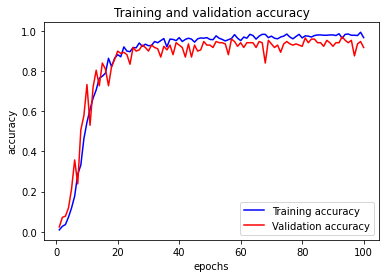

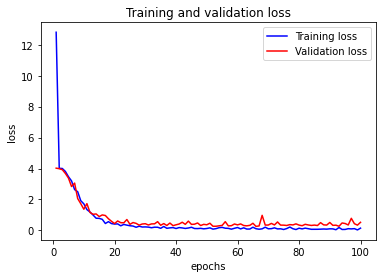

In [ ]:
# Learning curve
# plot the accuracy and loss plots between training and validation data
# verify overfitting or underfit 

model_cnn = create_cnn_model(activation='relu',dropout=0.2,optimizer='RMSprop',learn_rate=0.002)
history = model_cnn.fit(X_train[:,:,:,None], y_train, epochs=100, validation_data=(X_valid[:,:,:,None],y_valid),batch_size=64,verbose=0)

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
x = range(1,len(acc)+1)

plt.plot(x,acc,'b',label='Training accuracy')
plt.plot(x,val_acc,'r',label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.figure()

plt.plot(x,loss,'b',label='Training loss')
plt.plot(x,val_loss,'r',label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [ ]:
# classification report
predicted_classes = np.argmax(np.round(model_cnn.predict(X_test[:,:,:,None])),axis=1)
correct = np.where(predicted_classes==y_test)[0]
target_names = [f"Class {label}" for label in range(len(np.unique(df['label'])))]

print(f"From {len(y_test)} labels're founding {len(correct)} correct labels.")
print(f'Accuracy: {len(correct)/len(y_test)}')
print('')
print(classification_report(y_test, predicted_classes, target_names=target_names))

From 280 labels're founding 255 correct labels.
Accuracy: 0.9107142857142857

              precision    recall  f1-score   support

     Class 0       0.33      1.00      0.50         5
     Class 1       1.00      1.00      1.00         5
     Class 2       1.00      1.00      1.00         5
     Class 3       1.00      0.80      0.89         5
     Class 4       1.00      0.80      0.89         5
     Class 5       1.00      0.80      0.89         5
     Class 6       1.00      1.00      1.00         5
     Class 7       1.00      1.00      1.00         5
     Class 8       1.00      0.40      0.57         5
     Class 9       0.83      1.00      0.91         5
    Class 10       1.00      1.00      1.00         5
    Class 11       1.00      1.00      1.00         5
    Class 12       1.00      0.80      0.89         5
    Class 13       1.00      0.80      0.89         5
    Class 14       1.00      1.00      1.00         5
    Class 15       0.71      1.00      0.83         5
   

In [ ]:
index=[]
true = []
for i in range(len(y_test)):
    if y_test[i] == 0 or y_test[i] == 8 or y_test[i] == 39:
        index.append(i)
        true.append(y_test[i])

pred=[]
for i in index:
    pred.append(predicted_classes[i])

In [ ]:
true

[0, 0, 0, 0, 0, 39, 39, 39, 39, 39, 8, 8, 8, 8, 8]

In [ ]:
pred

[0, 0, 0, 0, 0, 15, 23, 39, 39, 23, 8, 23, 23, 0, 8]

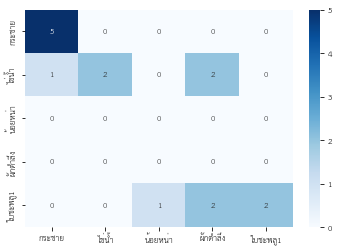

In [ ]:
!wget -q https://github.com/Phonbopit/sarabun-webfont/raw/master/fonts/thsarabunnew-webfont.ttf

mpl.font_manager.fontManager.addfont('thsarabunnew-webfont.ttf')
mpl.rc('font', family='TH Sarabun New', size=8)

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

cf_matrix = confusion_matrix(true, pred)

import seaborn as sns
sns.heatmap(cf_matrix, annot=True, xticklabels=['กระชาย','ไข่น้ำ','น้อยหน่า','ผักตำลึง','ใบชะพลู1'],yticklabels=['กระชาย','ไข่น้ำ','น้อยหน่า','ผักตำลึง','ใบชะพลู1'],cmap='Blues')

## Other people 
men and woman each 10 audio file.

In [ ]:
import numpy as np
np.random.seed(77)

random_fruit_veget = np.random.choice(np.unique(df['description']),10,replace=False).tolist()
print(random_fruit_veget)

['ผักกุยช่าย', 'ทับทิม', 'ใบชะพลู1', 'พริกขี้หนู', 'มันสำปะหลัง', 'ฟักทอง', 'มะพลับ', 'หัวหอม2', 'ใบชะพลู2', 'บวบ']


In [ ]:
import pandas as pd

# Audio data source
other_source = {'audio_time':[],
                'sampling_rate':[],
                'feature_extraction':[],
                'label':[],
                'description':[]}

for types in random_fruit_veget:
    audio_files = glob('/content/Project_499/Record_other_audio/' + str(types) + '/*.wav')

    for audio in audio_files:
        y,sr = librosa.load(audio,duration=5,offset=0)
        other_source['description'].append(str(types))
        other_source['audio_time'].append(y)
        other_source['sampling_rate'].append(sr)
        other_source['feature_extraction'].append(feature_mfcc(y,sr))

other_source['label'] = [18,18,14,14,39,39,44,44,37,37,50,50,25,25,55,55,40,40,38,38]
other_df = pd.DataFrame.from_dict(other_source)

In [ ]:
other_X_test = np.array(other_df['feature_extraction'].to_list())
other_y_test = np.array(other_df['label'].to_list())

In [ ]:
# classification report
predicted_classes = np.argmax(np.round(model_cnn.predict(other_X_test[:,:,:,None])),axis=1)
correct = np.where(predicted_classes==other_y_test)[0]
target_names = [f"Class {label}" for label in np.unique(other_source['label'])]

print(f"From {len(other_y_test)} labels're founding {len(correct)} correct labels.")
print(f'Accuracy: {len(correct)/len(other_y_test)}')

From 20 labels're founding 6 correct labels.
Accuracy: 0.3
